# Spaceship Titanic raw data preprocessing

## File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.\
    * `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.\
    * `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.\
    * `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.\
    * `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.\
    * `Destination` - The planet the passenger will be debarking to.\
    * `Age` - The age of the passenger.\
    * `VIP` - Whether the passenger has paid for special VIP service during the voyage.\
    * `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.\
    * `Name` - The first and last names of the passenger.\
    * `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.\
\
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.\
\
sample_submission.csv - A submission file in the correct format.\
    *PassengerId* - Id for each passenger in the test set.\
    *Transported* - The target. For each passenger, predict either True or False.\


In [180]:
import os
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
%matplotlib inline

## 1 - Load environmental variables

In [170]:
project_dir = str(Path().resolve().parents[0])
dotenv_path = os.path.join(project_dir, '.env')
env_var = dotenv.load_dotenv(dotenv_path)
raw_data_path = os.environ.get("RAW_DATA_PATH")

## 2 - Read raw data
The infer_objects function automatically identifies the dtypes for each column

In [171]:
train_raw_data = pd.read_csv(os.path.join(project_dir, raw_data_path, "train.csv")).infer_objects()
test_raw_data =  pd.read_csv(os.path.join(project_dir, raw_data_path, "test.csv")).infer_objects()

test_raw_data["Transported"] = [-1] * test_raw_data.shape[0]
test_raw_data["dataset"] = ["test"] * test_raw_data.shape[0]
train_raw_data["dataset"] = ["train"] * train_raw_data.shape[0]

raw_data = pd.concat([train_raw_data, test_raw_data])
raw_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,train
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,train
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,train
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,-1,test
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,-1,test
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,-1,test
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,-1,test


# 3 - Create New Features

In [172]:
data_new_features = raw_data.copy()
# Create new feature from PassangerId 
data_new_features["PassengerGroup"] =  data_new_features["PassengerId"].str.split("_").str[0]
data_new_features["PassengerGroupId"] =  data_new_features["PassengerId"].str.split("_").str[1]
data_new_features["PassengerGroupId"] =  data_new_features["PassengerId"].str.split("_").str[1]
# Create new featyres from Cabin
data_new_features["CabinDeck"] =  data_new_features["Cabin"].str.split("/").str[0]
data_new_features["CabinNum"] =  pd.to_numeric(data_new_features["Cabin"].str.split("/").str[1], errors="coerce")
data_new_features["CabinSide"] =  data_new_features["Cabin"].str.split("/").str[2]


data_new_features.set_index("PassengerId", inplace=True)

#Create new feauture from PassengerGroup
for group, group_data in data_new_features.groupby(by="PassengerGroup"):
    travelling_together = len(group_data)
    data_new_features.loc[group_data.index, "TravelingTogether"] =  [travelling_together] * len(group_data)

#Create new feature from CabinNum * CabinDeck
weights = [10**p for p in range(1,9)]
keys = data_new_features["CabinDeck"].unique()
deck_mapper = dict(zip(keys, weights))    
cabin_deck_weights= data_new_features["CabinDeck"].map(deck_mapper)
data_new_features["CabinNumWeighted"] = data_new_features["CabinNum"] + cabin_deck_weights

# Remove columns 
data_new_features.drop(columns=["Cabin", "PassengerGroup", "Name"], inplace=True)
data = data_new_features
data

# Create feature to check if the passenger is reach based on its spents

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,dataset,PassengerGroupId,CabinDeck,CabinNum,CabinSide,TravelingTogether,CabinNumWeighted
PassengerId,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,train,01,B,0.0,P,1.0,10.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,train,01,F,0.0,S,1.0,100.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,train,01,A,0.0,S,2.0,1000.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,train,02,A,0.0,S,2.0,1000.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,train,01,F,1.0,S,1.0,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,-1,test,02,G,1496.0,S,2.0,11496.0
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,-1,test,01,NaN,NaN,NaN,1.0,NaN
9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,-1,test,01,D,296.0,P,1.0,10000296.0


### 3.1 Checking columns dtypes

In [173]:
print(f"Number of columns: {data.shape[1]}")
data.dtypes

Number of columns: 18


HomePlanet            object
CryoSleep             object
Destination           object
Age                  float64
VIP                   object
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Transported            int64
dataset               object
PassengerGroupId      object
CabinDeck             object
CabinNum             float64
CabinSide             object
TravelingTogether    float64
CabinNumWeighted     float64
dtype: object

In [174]:
numerical_cols = data.select_dtypes(include="float64").columns.to_list()
categorical_cols = data.select_dtypes(include="object").columns.to_list()
categorical_cols.remove("dataset")
target_col = ["Transported"]
print(f"Numerical columns: {numerical_cols}")
print(f"Categorival columns: {categorical_cols}")
print(f"Target column: {target_col}")

Numerical columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'TravelingTogether', 'CabinNumWeighted']
Categorival columns: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'PassengerGroupId', 'CabinDeck', 'CabinSide']
Target column: ['Transported']


# 4 - Convert categorical features to numerical

In [175]:
data_dummies = pd.get_dummies(data, columns=categorical_cols, dummy_na=True)
data = data_dummies


## 5 - Missing data imputation

In [176]:
for dataset, data in data.groupby(by="dataset"):
    print(dataset)
    print(f"Number of NaN values: {data.isna().sum().sum()}/{data.size}")
    print(f"Number of columns with NaN: {data.isna().any().sum()}/{data.shape[1]}")
    print(f"Number of rows with NaN: {data.isna().any(axis=1).sum()}/{data.shape[0]}")
# ToDo: 
# We need to inputate missing data for all columns 
# We need to check if this is possible


test
Number of NaN values: 764/196742
Number of columns with NaN: 8/46
Number of rows with NaN: 635/4277
train
Number of NaN values: 1525/399878
Number of columns with NaN: 8/46
Number of rows with NaN: 1256/8693


In [177]:
for col in numerical_cols:
    data[col].fillna((data[col].mean()), inplace=True)
    
for dataset, data in data.groupby(by="dataset"):
    print(dataset)
    print(f"Number of NaN values: {data.isna().sum().sum()}/{data.size}")
    print(f"Number of columns with NaN: {data.isna().any().sum()}/{data.shape[1]}")
    print(f"Number of rows with NaN: {data.isna().any(axis=1).sum()}/{data.shape[0]}")
data

train
Number of NaN values: 0/399878
Number of columns with NaN: 0/46
Number of rows with NaN: 0/8693


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,dataset,CabinNum,TravelingTogether,...,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_nan,CabinSide_P,CabinSide_S,CabinSide_nan
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,train,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,1,train,0.0,1.0,...,0,0,0,1,0,0,0,0,1,0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0,train,0.0,2.0,...,0,0,0,0,0,0,0,0,1,0
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,train,0.0,2.0,...,0,0,0,0,0,0,0,0,1,0
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1,train,1.0,1.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,0,train,98.0,1.0,...,0,0,0,0,0,0,0,1,0,0
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,0,train,1499.0,1.0,...,0,0,0,0,1,0,0,0,1,0
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,1,train,1500.0,1.0,...,0,0,0,0,1,0,0,0,1,0


## 6 - Standarize the data by fixed terms

In [179]:
mean_numerical_cols = data[numerical_cols].mean()
std_numerical_cols = data[numerical_cols].std()
data[numerical_cols] = (data[numerical_cols] - mean_numerical_cols)/ std_numerical_cols

print('Mean used for standarizantion is:')
print(mean_numerical_cols)
print('Standard Deviation used for standarizantion is:')
print(std_numerical_cols)

data



Mean used for standarizantion is:
Age                  2.882793e+01
RoomService          2.246876e+02
FoodCourt            4.580772e+02
ShoppingMall         1.737292e+02
Spa                  3.111388e+02
VRDeck               3.048548e+02
CabinNum             6.003677e+02
TravelingTogether    2.035546e+00
CabinNumWeighted     9.469576e+06
dtype: float64
Standard Deviation used for standarizantion is:
Age                  1.433905e+01
RoomService          6.597394e+02
FoodCourt            1.594435e+03
ShoppingMall         5.974174e+02
Spa                  1.124676e+03
VRDeck               1.133259e+03
CabinNum             5.059738e+02
TravelingTogether    1.596347e+00
CabinNumWeighted     2.788253e+07
dtype: float64


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,dataset,CabinNum,TravelingTogether,...,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_nan,CabinSide_P,CabinSide_S,CabinSide_nan
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0.709396,-0.340570,-0.287298,-0.290800,-0.276648,-0.269007,0,train,-1.186559,-0.648697,...,0,0,0,0,0,0,0,1,0,0
0002_01,-0.336698,-0.175354,-0.281653,-0.248954,0.211493,-0.230181,1,train,-1.186559,-0.648697,...,0,0,0,1,0,0,0,0,1,0
0003_01,2.034449,-0.275393,1.955503,-0.290800,5.693962,-0.225769,0,train,-1.186559,-0.022267,...,0,0,0,0,0,0,0,0,1,0
0003_02,0.290958,-0.340570,0.517376,0.330206,2.683316,-0.098702,0,train,-1.186559,-0.022267,...,0,0,0,0,0,0,0,0,1,0
0004_01,-0.894615,0.118702,-0.243395,-0.038046,0.225719,-0.267242,1,train,-1.184582,-0.648697,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.848875,-0.340570,3.989453,-0.290800,1.184218,-0.203709,0,train,-0.992873,-0.648697,...,0,0,0,0,0,0,0,1,0,0
9278_01,-0.755136,-0.340570,-0.287298,-0.290800,-0.276648,-0.269007,0,train,1.776045,-0.648697,...,0,0,0,0,1,0,0,0,1,0
9279_01,-0.197219,-0.340570,-0.287298,2.842687,-0.275758,-0.269007,1,train,1.778022,-0.648697,...,0,0,0,0,1,0,0,0,1,0


# 7 - Visualize Data

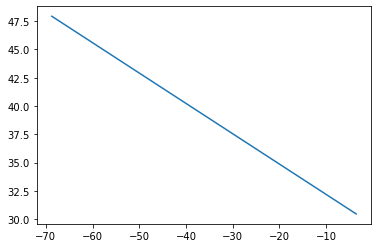

In [181]:
train_data = data[data["dataset"]=="train"]
y_data = train_data["Transported"]
x_data = train_data.drop(columns=["dataset", "Transported"])


X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random').fit_transform(x_data)





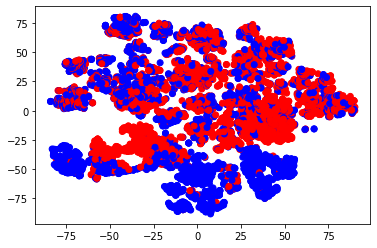

In [189]:
import matplotlib
colors = ["red", "blue"]
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y_data.to_list(), cmap=matplotlib.colors.ListedColormap(colors))